In [116]:
import stable_baselines3
import gym
import numpy as np

# Environement
import gym
from gym import spaces

# Evaluate the environement
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.monitor import Monitor

# Agent
from stable_baselines3 import A2C,DQN
# Policy
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.policies import ActorCriticPolicy


import matplotlib.pyplot as plt
import os

/tmp/ipykernel_940/1742204415.py:20: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output as clo, display
/tmp/ipykernel_940/1742204415.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output as clo, display


In [93]:
SOLUTION_NAME = "StbBL_Base"
log_dir = SOLUTION_NAME + "/"
os.makedirs(log_dir, exist_ok=False)

FileExistsError: [Errno 17] File exists: 'StbBL_Base/'

# Environement

## Definition

In [107]:
class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    CASE_VIDE = 255
    
    def __init__(self, grid_size=(10,10),nspecies=8):
        # CONTROLES DONNEES
        assert nspecies < 256-1 # pour compatibilité avec uint8. 0 est pris par l'information case vide
        
        # INITILISATIION SUBCLASS
        super().__init__()
        
        
        # PARAMETRES 
        self.grid_size = grid_size
        self.nspecies = nspecies

        
        
        # Define action space
        # ESSAI 1 : NE MARCHE PAS, CE SONT DES VALEURS CONTINUES MEME AVEC dype
#         self.action_space = spaces.Box(low=np.array([0,0,0]),
#                                       high=np.array(self.grid_size + (self.nspecies,)),
#                                       shape=(3,),
#                                       dtype=np.uint8)        
        # ESSAI 2 :
        self.action_space =spaces.MultiDiscrete(self.grid_size + (self.nspecies,))

        # ESSAI 3 : Pour passage DQN
#         self.action_space =spaces.Discrete(np.prod(self.grid_size + (self.nspecies,))
        
        # Define observation space
        self.observation_space = spaces.Box(low=0,
                                            high=self.nspecies,
                                            shape=grid_size, dtype=np.uint8)
        
        self.state = np.full(self.grid_size,self.CASE_VIDE)
    
    
    def step(self, action):
        # ACTION -> ACTION LOCALE
        x,y,specie = action
        
        
        # CONTROLE
        assert specie != self.CASE_VIDE
        
        done = False # JUSQU'A PREUVE DU CONTRAIRE LA PARTIE CONTINUE
        info = {} # UTILISE POUR DEBUGAGE
        reward = 0
        if self.state[x,y]==self.CASE_VIDE:
            # ACTION VALIDE (CASE LIBRE) CAR ==0            
            self.state[x,y] = specie # ON PLANTE
            reward = 1 # <--------------------------------------------------REWARD NON LEGUME
            if (self.state[x,y]!=self.CASE_VIDE).sum()==0:
                # DANS LE CAS ON IL N'Y A PLUS DE CASES VIDES
                reward = 100 # <--------------------------------------------------REWARD SUCCESS
                done = True 
            
        else:
            # ACTION NON VALIDE CASE DEJA REMPLIE
            reward = -100 # <--------------------------------------------------REWARD FAIL
            done = True
            
        return self.to_observation(), reward, done, info
    
    def reset(self):
#         self.state = np.full(self.grid_size,self.CASE_VIDE) # TODO ESSAYER DE FAIRE UN RANDOM A CHAQUE RESET PLUTOT 0, COMME SUGGERE PAR GUILLAUME
        self.state = self.observation_space.sample() # TODO ESSAYER DE FAIRE UN RANDOM A CHAQUE RESET PLUTOT 0, COMME SUGGERE PAR GUILLAUME
        return self.to_observation()
    
    def to_observation(self):
        return self.state.copy()
    
    def render(self,mode="human"):
        return self.to_observation()
        


## Instanciation

In [108]:
env = CustomEnv(grid_size=(4,4),nspecies=1)
eval_env = CustomEnv(grid_size=(4,4),nspecies=1) # Use a separate environement for evaluation
env = Monitor(env, log_dir)

# Agent

In [125]:
# algo_with_policy = DQN(MlpPolicy, env, verbose=2)
algo_with_policy = A2C(MlpPolicy, env, verbose=2,)

Using cpu device
Wrapping the env in a DummyVecEnv.


## Evaluate initial Agent

In [126]:
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(algo_with_policy, eval_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-100.00 +/- 0.00


## Train the agent

In [127]:
class MyCallBack(BaseCallback):
    def __init__(self,log_dir,steps_to_print,verbose=0):
        super().__init__()
        self.log_dir = log_dir
        self.steps_to_print = steps_to_print
        
    def _on_step(self) -> bool:
        if self.num_timesteps % self.steps_to_print == 0:
            plt.imshow(self.locals["obs_tensor"].numpy()[0,:,:])
            plt.show()


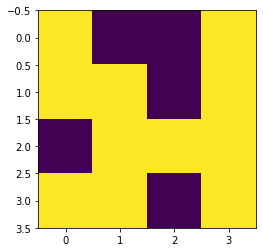

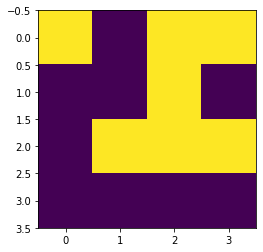

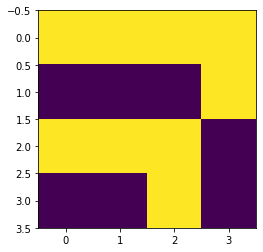

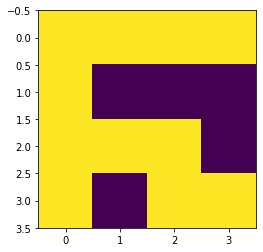

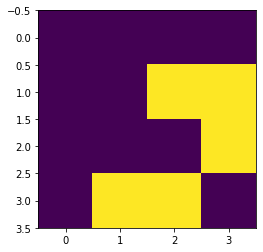

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 399      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.75    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -238     |
|    value_loss         | 7.22e+03 |
------------------------------------


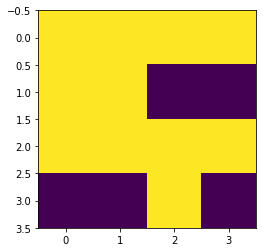

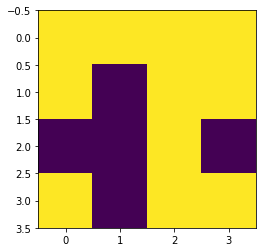

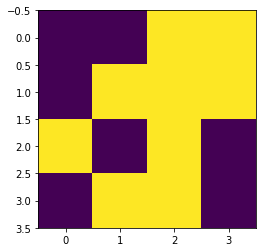

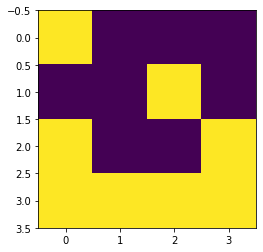

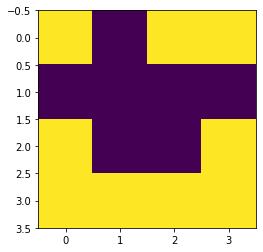

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 407      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -2.75    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -208     |
|    value_loss         | 6.32e+03 |
------------------------------------


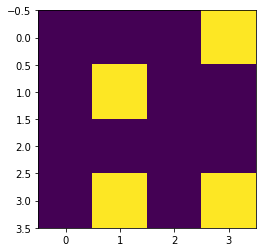

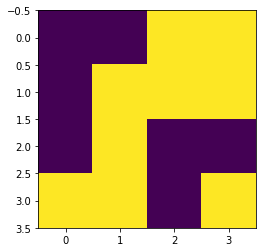

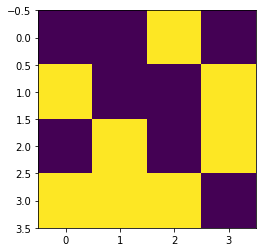

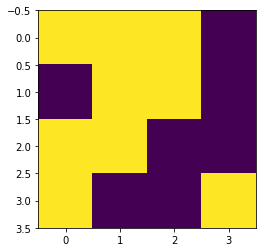

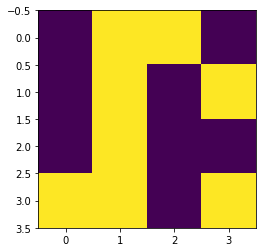

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 413      |
|    iterations         | 300      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -2.74    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | -202     |
|    value_loss         | 5.58e+03 |
------------------------------------


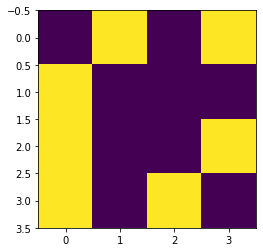

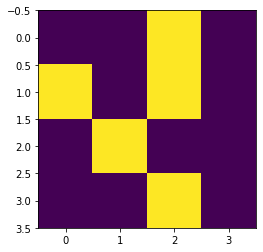

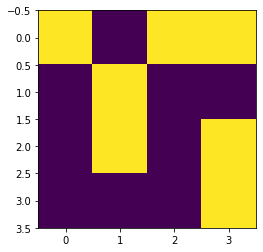

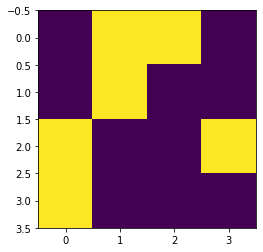

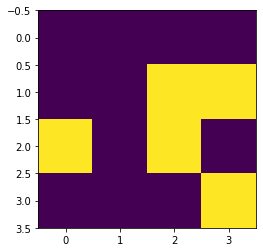

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 419      |
|    iterations         | 400      |
|    time_elapsed       | 4        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -2.74    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 399      |
|    policy_loss        | -186     |
|    value_loss         | 4.91e+03 |
------------------------------------


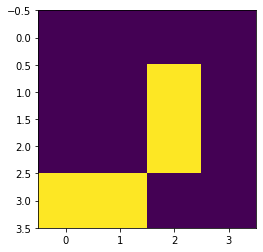

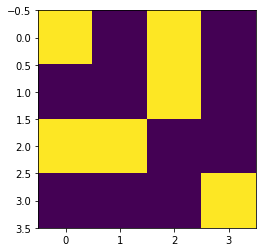

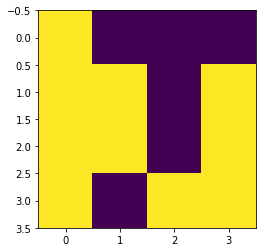

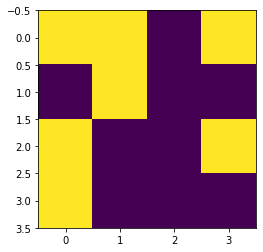

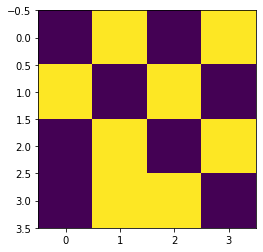

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 420      |
|    iterations         | 500      |
|    time_elapsed       | 5        |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -2.75    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 499      |
|    policy_loss        | -170     |
|    value_loss         | 4.29e+03 |
------------------------------------


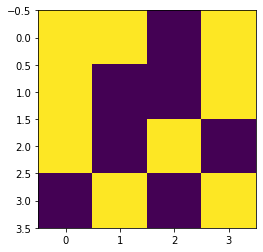

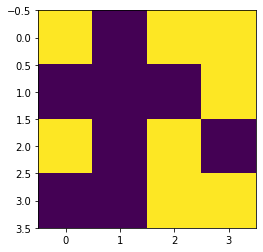

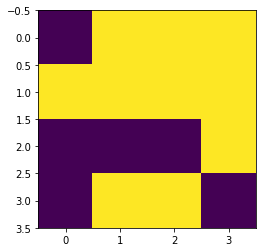

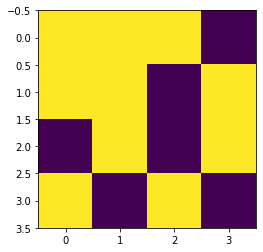

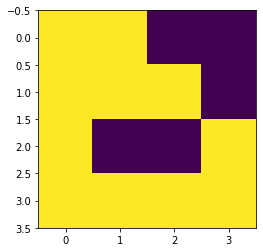

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 413      |
|    iterations         | 600      |
|    time_elapsed       | 7        |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -2.69    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 599      |
|    policy_loss        | -158     |
|    value_loss         | 3.71e+03 |
------------------------------------


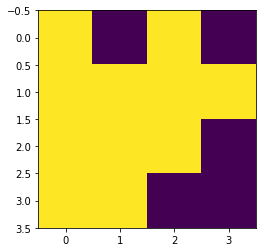

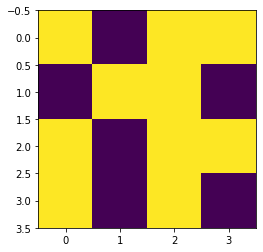

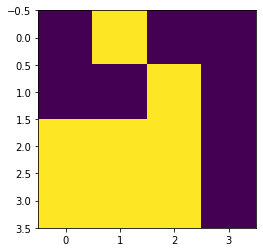

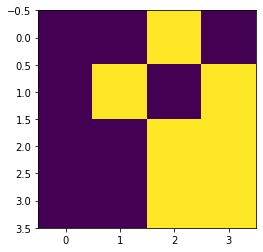

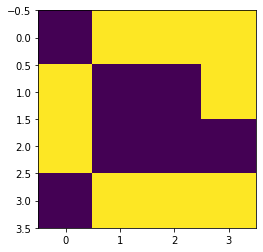

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 411      |
|    iterations         | 700      |
|    time_elapsed       | 8        |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -2.73    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | -167     |
|    value_loss         | 3.18e+03 |
------------------------------------


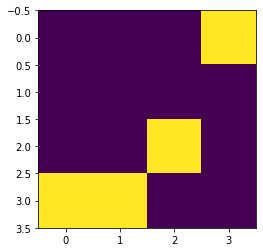

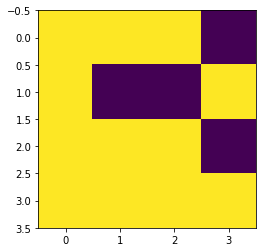

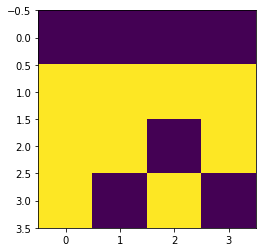

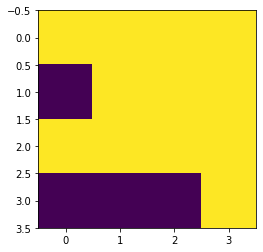

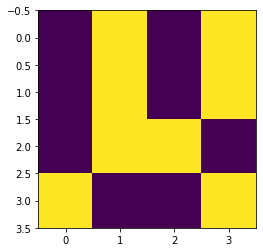

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 406      |
|    iterations         | 800      |
|    time_elapsed       | 9        |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -2.71    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 799      |
|    policy_loss        | -134     |
|    value_loss         | 2.69e+03 |
------------------------------------


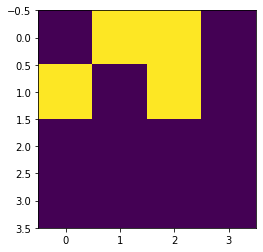

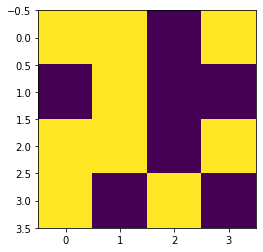

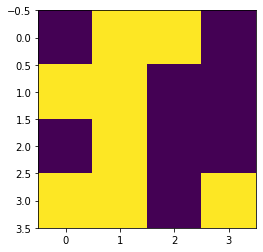

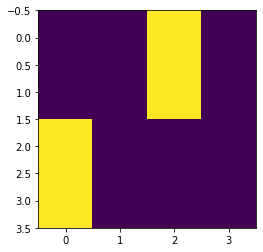

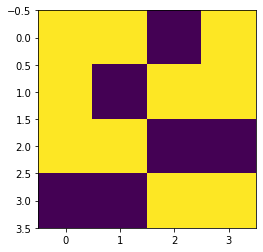

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 398      |
|    iterations         | 900      |
|    time_elapsed       | 11       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -2.71    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 899      |
|    policy_loss        | -128     |
|    value_loss         | 2.24e+03 |
------------------------------------


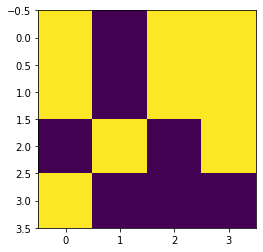

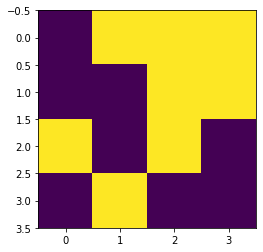

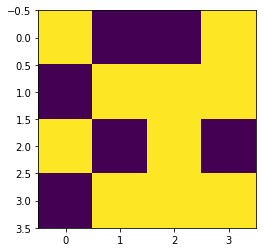

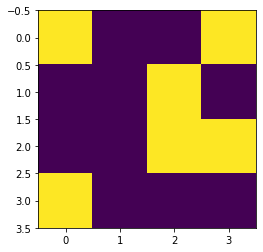

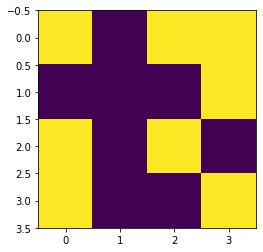

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 400      |
|    iterations         | 1000     |
|    time_elapsed       | 12       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -2.38    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 999      |
|    policy_loss        | -80.6    |
|    value_loss         | 1.83e+03 |
------------------------------------


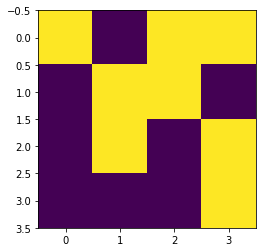

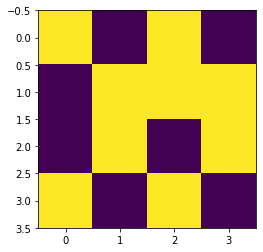

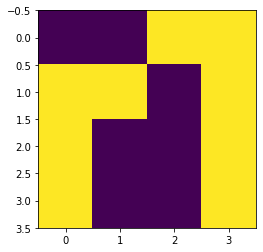

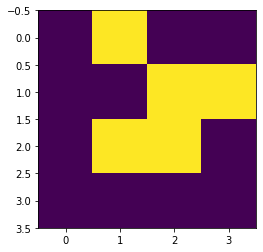

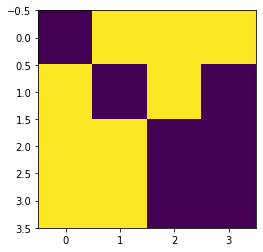

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 401      |
|    iterations         | 1100     |
|    time_elapsed       | 13       |
|    total_timesteps    | 5500     |
| train/                |          |
|    entropy_loss       | -2.62    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1099     |
|    policy_loss        | -119     |
|    value_loss         | 1.46e+03 |
------------------------------------


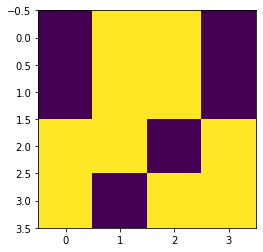

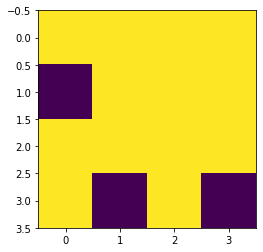

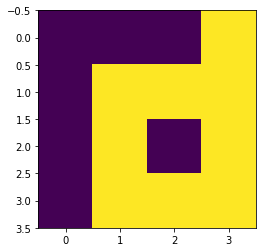

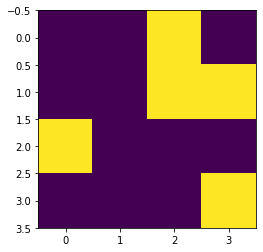

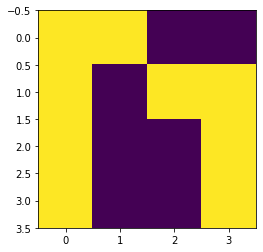

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 403      |
|    iterations         | 1200     |
|    time_elapsed       | 14       |
|    total_timesteps    | 6000     |
| train/                |          |
|    entropy_loss       | -2.63    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1199     |
|    policy_loss        | -101     |
|    value_loss         | 1.13e+03 |
------------------------------------


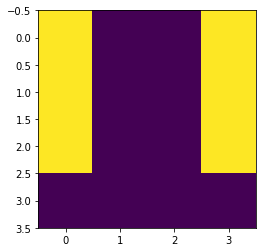

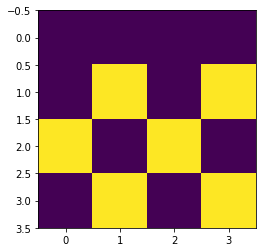

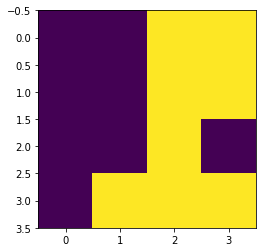

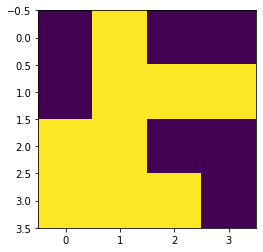

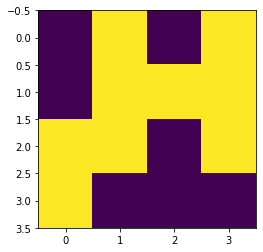

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 401      |
|    iterations         | 1300     |
|    time_elapsed       | 16       |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -2.72    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1299     |
|    policy_loss        | -85.3    |
|    value_loss         | 846      |
------------------------------------


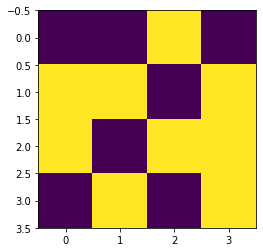

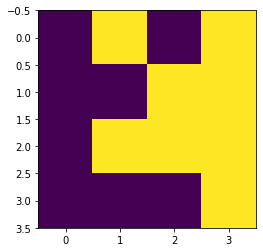

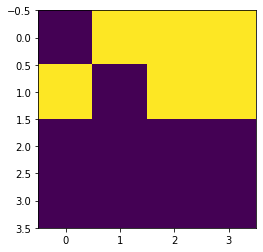

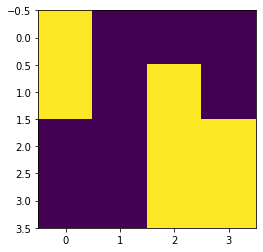

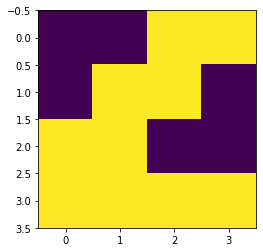

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 399      |
|    iterations         | 1400     |
|    time_elapsed       | 17       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -2.67    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | -60.8    |
|    value_loss         | 602      |
------------------------------------


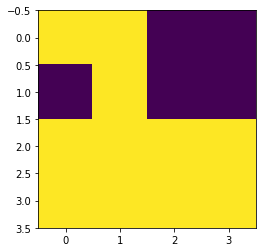

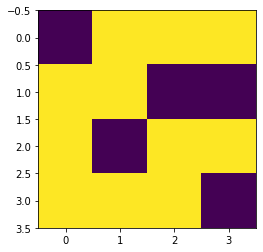

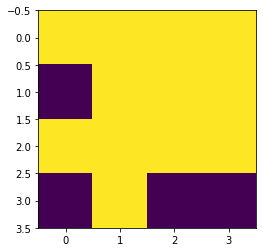

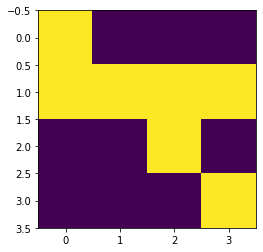

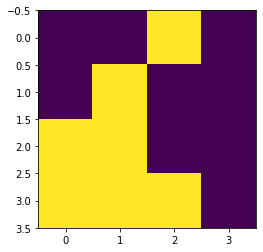

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 397      |
|    iterations         | 1500     |
|    time_elapsed       | 18       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -2.62    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1499     |
|    policy_loss        | -59.6    |
|    value_loss         | 400      |
------------------------------------


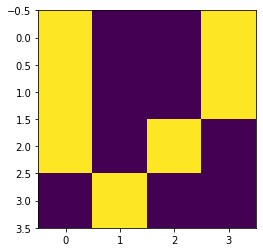

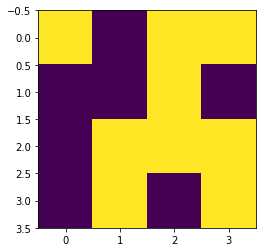

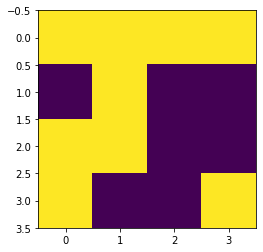

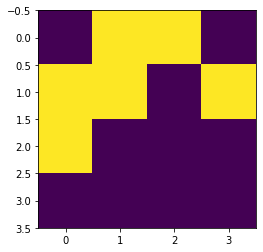

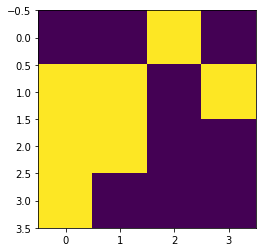

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 396      |
|    iterations         | 1600     |
|    time_elapsed       | 20       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -2.61    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1599     |
|    policy_loss        | -43.8    |
|    value_loss         | 239      |
------------------------------------


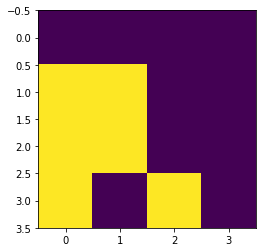

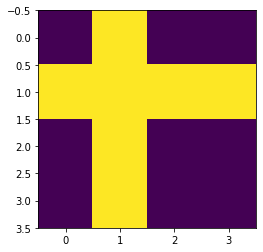

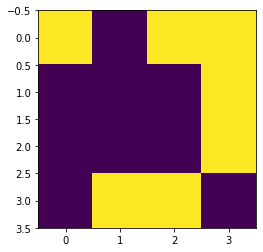

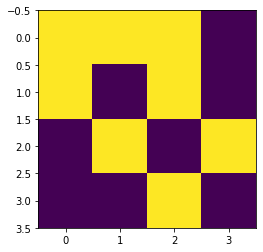

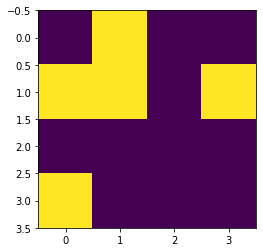

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -100     |
| time/                 |          |
|    fps                | 392      |
|    iterations         | 1700     |
|    time_elapsed       | 21       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -2.69    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss        | -29.4    |
|    value_loss         | 119      |
------------------------------------


KeyboardInterrupt: 

In [128]:
# Train the agent for 10000 steps
callback = MyCallBack(log_dir,100)
algo_with_policy.learn(total_timesteps=100000,callback=callback)

## Evaluate agent 

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(algo_with_policy, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [138]:
N=np.prod(env.grid_size)

In [130]:
env.reset()

array([[0, 0, 0, 1],
       [0, 0, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 0]], dtype=uint8)

In [133]:
env.state==0

array([[ True,  True,  True, False],
       [ True,  True, False, False],
       [False, False, False,  True],
       [False, False, False,  True]])